In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
sequence_length = 4
input_size = 1
batch = 128
hidden_size = 128
num_layers = 1
num_epochs = 1000
learning_rate = 0.01

In [3]:
def generate():
    x = np.random.randint(3, size=(sequence_length,batch,input_size)) - 1
    y = np.zeros((batch,1))
    for i in range(batch):
        unique, counts = np.unique(x[:,i,:], return_counts=True)
        try:
            y[i,0] = dict(zip(unique, counts))[1]%2
        except:
            y[i,0] = 0
    x = Variable(torch.from_numpy(x).float())
    y = Variable(torch.from_numpy(y).float())
    return x, y



In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Forward propagate RNN
        (h0, c0) = self.init_hidden_state()
        out, (h0, c0) = self.lstm(x, (h0, c0))
        out = out[-1,:,:]
        out = self.fc(out)
        out = F.sigmoid(out)
        return out
    
    def init_hidden_state(self):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size).cuda()) 
            c0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size)) 
            c0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size))
        return h0, c0

rnn = RNN(input_size, hidden_size, num_layers)
if torch.cuda.is_available():
    rnn.cuda()

In [5]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [6]:
def accuracy(y,out):
    y = y.data.numpy()
    out = out.data.numpy()
    out = np.round(out)
    return 1 - (sum(abs(y-out))/(batch))

In [7]:
losses = np.zeros(num_epochs)
acc = np.zeros(num_epochs)
for i in range(num_epochs):
    rnn.zero_grad()
    x,y = generate()
    out = rnn(x)
    loss = criterion(out,y)
    losses[i] = loss.data[0]
    acc[i] = accuracy(out,y)
    loss.backward()
    optimizer.step()
    if (i+1)%(num_epochs//20) == 0:
        print('Step '+ str(i+1) + '/' +str(num_epochs)+' done. Loss = ' + str(losses[i])+ '. Accuracy = ' + str(acc[i]))

Step 50/1000 done. Loss = 0.570147871971. Accuracy = 0.594073057175
Step 100/1000 done. Loss = 0.0119584463537. Accuracy = 0.988232314587
Step 150/1000 done. Loss = 0.00098523683846. Accuracy = 0.999015986919
Step 200/1000 done. Loss = 0.000719463452697. Accuracy = 0.999281108379
Step 250/1000 done. Loss = 0.00048854004126. Accuracy = 0.99951171875
Step 300/1000 done. Loss = 0.000302975386148. Accuracy = 0.9996971488
Step 350/1000 done. Loss = 0.000214911880903. Accuracy = 0.999785125256
Step 400/1000 done. Loss = 0.000205228367122. Accuracy = 0.999794840813
Step 450/1000 done. Loss = 0.000153186934767. Accuracy = 0.999846816063
Step 500/1000 done. Loss = 0.000133979337988. Accuracy = 0.999866068363
Step 550/1000 done. Loss = 0.000110928267532. Accuracy = 0.999889075756
Step 600/1000 done. Loss = 9.84548678389e-05. Accuracy = 0.999901533127
Step 650/1000 done. Loss = 9.04326152522e-05. Accuracy = 0.999909579754
Step 700/1000 done. Loss = 7.06960781827e-05. Accuracy = 0.999929308891
Ste

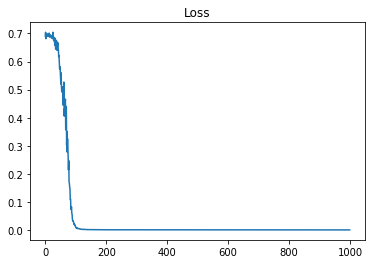

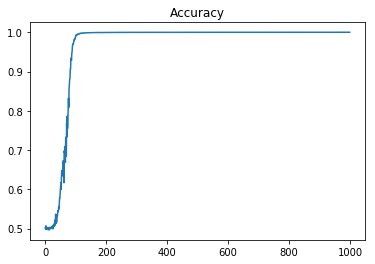

In [8]:
%matplotlib inline
plt.plot(losses)
plt.title('Loss')
plt.figure()
plt.plot(acc)
plt.title('Accuracy')